[ELBOW RESULTS] KMeans best k: 10, GMM best k: 7 => Using consensus k=8


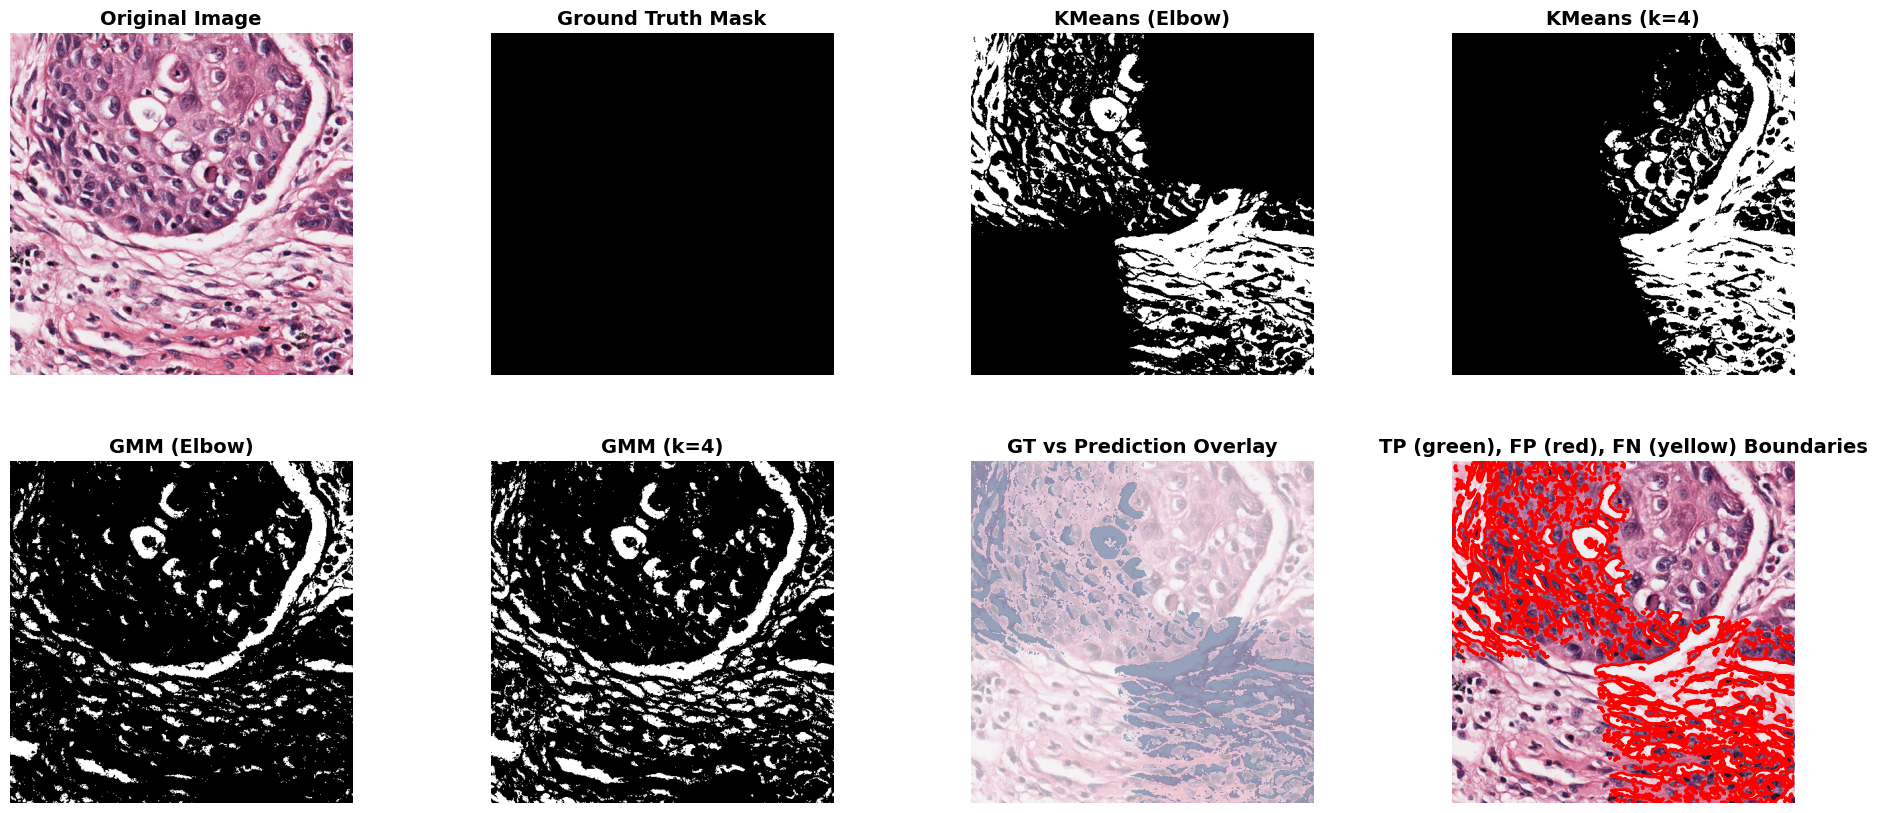

Combined visualization saved: pixel_level/evaluation1/combined_segmentation_visualization_4col_pixel.png
Individual visualizations saved in pixel_level/evaluation1


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import cv2
import tifffile

# === Pixel-level clustering functions === #

def extract_pixel_features(image):
    """Extract pixel-level features: RGB + normalized XY coordinates."""
    h, w = image.shape[:2]
    coords = np.indices((h, w)).transpose(1, 2, 0)  # shape (h, w, 2)
    norm_x = coords[..., 1] / w
    norm_y = coords[..., 0] / h
    rgb = image.reshape(-1, 3)
    xy = np.stack([norm_x.ravel(), norm_y.ravel()], axis=1)
    features = np.concatenate([rgb, xy], axis=1)
    return features

def elbow_kmeans_gmm(features, max_k=10):
    ks = list(range(2, max_k + 1))
    kmeans_scores, gmm_scores = [], []
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(features)
        kmeans_scores.append(kmeans.inertia_)
        gmm = GaussianMixture(n_components=k, random_state=42).fit(features)
        gmm_scores.append(-gmm.score(features))
    return ks, kmeans_scores, gmm_scores

def find_elbow(scores):
    diff1 = np.diff(scores)
    diff2 = np.diff(diff1)
    elbow_index = np.argmin(diff2) + 2  # Offset for 2nd diff
    return elbow_index

def cluster_with_methods_pixel(features, shape, n_clusters):
    masks = {}

    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(features)
    masks['kmeans'] = kmeans.labels_.reshape(shape)

    # GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42).fit(features)
    masks['gmm'] = gmm.predict(features).reshape(shape)

    return masks

# === Visualization functions === #

def add_border(ax, color='black', lw=2):
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(lw)

def binarize_cluster_mask(mask, image_gray, method='max_intensity'):
    clusters = np.unique(mask)
    means = [image_gray[mask == c].mean() for c in clusters]
    threshold = np.percentile(means, 75)
    binary = np.isin(mask, [c for c, m in zip(clusters, means) if m >= threshold]).astype(np.uint8)
    return binary

def visualize_all_and_save(image, gt_mask, masks_dict, save_dir, nuclei_cluster_method='max_intensity'):
    os.makedirs(save_dir, exist_ok=True)

    image_gray = image.mean(axis=2) if image.ndim == 3 else image
    binary_masks = {}
    for key, mask in masks_dict.items():
        binary_masks[key] = binarize_cluster_mask(mask, image_gray, nuclei_cluster_method)
    binary_masks['gt_mask'] = gt_mask
    binary_masks['original'] = image

    keys_order = ['original', 'gt_mask',
                  'kmeans_elbow', 'kmeans_4',
                  'gmm_elbow', 'gmm_4',
                  'overlay', 'tp_fp_fn']
    titles = ['Original Image', 'Ground Truth Mask',
              'KMeans (Elbow)', 'KMeans (k=4)',
              'GMM (Elbow)', 'GMM (k=4)',
              'GT vs Prediction Overlay', 'TP (green), FP (red), FN (yellow) Boundaries']

    overlay_gt = binary_masks['gt_mask']
    # Let's define overlay_pred as kmeans_elbow mask for simplicity
    overlay_pred = binary_masks['kmeans_elbow']

    tp_mask = (overlay_gt == 1) & (overlay_pred == 1)
    fp_mask = (overlay_gt == 0) & (overlay_pred == 1)
    fn_mask = (overlay_gt == 1) & (overlay_pred == 0)

    fig, axes = plt.subplots(2, 4, figsize=(24, 10))
    axes = axes.flatten()

    for i, key in enumerate(keys_order):
        ax = axes[i]
        if key == 'original':
            ax.imshow(image)
        elif key == 'gt_mask':
            ax.imshow(binary_masks[key], cmap='gray')
        elif key in binary_masks:
            ax.imshow(binary_masks[key], cmap='gray')
        elif key == 'overlay':
            ax.imshow(image)
            ax.imshow(overlay_gt, cmap='Reds', alpha=0.4)
            ax.imshow(overlay_pred, cmap='Blues', alpha=0.4)
        elif key == 'tp_fp_fn':
            ax.imshow(image)
            for mask_, color in zip([tp_mask, fp_mask, fn_mask], ['green', 'red', 'yellow']):
                contours = measure.find_contours(mask_, 0.5)
                for contour in contours:
                    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color=color)

        ax.set_title(titles[i], fontsize=14, weight='bold')
        ax.axis('off')
        add_border(ax, color='black', lw=2)

    plt.subplots_adjust(wspace=0.15, hspace=0.25)
    combined_path = os.path.join(save_dir, "combined_segmentation_visualization_4col_pixel.png")
    plt.savefig(combined_path, bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()
    print(f"Combined visualization saved: {combined_path}")

    # Save individual plots
    for i, key in enumerate(keys_order):
        fig_ind, ax_ind = plt.subplots(1, 1, figsize=(6, 6))
        if key == 'original':
            ax_ind.imshow(image)
        elif key == 'gt_mask':
            ax_ind.imshow(binary_masks[key], cmap='gray')
        elif key in binary_masks:
            ax_ind.imshow(binary_masks[key], cmap='gray')
        elif key == 'overlay':
            ax_ind.imshow(image)
            ax_ind.imshow(overlay_gt, cmap='Reds', alpha=0.4)
            ax_ind.imshow(overlay_pred, cmap='Blues', alpha=0.4)
        elif key == 'tp_fp_fn':
            ax_ind.imshow(image)
            for mask_, color in zip([tp_mask, fp_mask, fn_mask], ['green', 'red', 'yellow']):
                contours = measure.find_contours(mask_, 0.5)
                for contour in contours:
                    ax_ind.plot(contour[:, 1], contour[:, 0], linewidth=2, color=color)

        ax_ind.set_title(titles[i], fontsize=16, weight='bold')
        ax_ind.axis('off')
        add_border(ax_ind, color='black', lw=3)
        fname = key if key != 'gt_mask' else 'gt'
        save_fp = os.path.join(save_dir, f"{fname}.png")
        fig_ind.savefig(save_fp, bbox_inches='tight', dpi=150)
        plt.close(fig_ind)

    print(f"Individual visualizations saved in {save_dir}")

# === Main pixel-level execution === #

def main_pixel_level():
    image_path = 'TCGA-21-5784-01Z-00-DX1.tif'  # Update path as needed
    image = tifffile.imread(image_path)
    max_dim = 512
    scale = max_dim / max(image.shape[:2])
    if scale < 1:
        image = cv2.resize(image, (int(image.shape[1]*scale), int(image.shape[0]*scale)))
    image_float = image.astype(np.float32) / 255.0

    # Extract pixel features
    features = extract_pixel_features(image_float)
    shape = image_float.shape[:2]

    # Elbow analysis
    ks, kmeans_scores, gmm_scores = elbow_kmeans_gmm(features)

    best_k = ks[find_elbow(kmeans_scores)]
    best_gmm = ks[find_elbow(gmm_scores)]
    final_k = int(np.median([best_k, best_gmm]))

    print(f"[ELBOW RESULTS] KMeans best k: {best_k}, GMM best k: {best_gmm} => Using consensus k={final_k}")

    # Cluster with elbow k
    masks_elbow = cluster_with_methods_pixel(features, shape, final_k)
    # Cluster with k=4 for comparison
    masks_k4 = cluster_with_methods_pixel(features, shape, 4)

    # Load your GT mask here as uint8 (binary)
    gt_mask = np.zeros(shape, dtype=np.uint8)  # Replace with actual GT mask loading

    masks_dict = {
        'kmeans_elbow': masks_elbow['kmeans'],
        'kmeans_4': masks_k4['kmeans'],
        'gmm_elbow': masks_elbow['gmm'],
        'gmm_4': masks_k4['gmm'],
    }

    save_dir = 'pixel_level/evaluation1'
    visualize_all_and_save(image_float, gt_mask, masks_dict, save_dir)

if __name__ == "__main__":
    main_pixel_level()


In [ ]:
## full code
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.segmentation import slic, mark_boundaries
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import skfuzzy as fuzz
from scipy.cluster.hierarchy import linkage, fcluster
import tifffile

def extract_features(image):
    """Extract pixel-level features: RGB + normalized XY coordinates."""
    h, w = image.shape[:2]
    x_coords, y_coords = np.meshgrid(np.arange(w), np.arange(h))
    x_norm = x_coords / w
    y_norm = y_coords / h
    rgb = image.reshape(-1, 3)
    features = np.concatenate([rgb, x_norm.reshape(-1, 1), y_norm.reshape(-1, 1)], axis=1)
    return features

def consensus_clustering(label_lists, n_clusters):
    n = len(label_lists[0])
    coassoc = np.zeros((n, n))
    for labels in label_lists:
        for i in range(n):
            for j in range(n):
                if labels[i] == labels[j]:
                    coassoc[i, j] += 1
    coassoc /= len(label_lists)
    dist = 1 - coassoc
    Z = linkage(dist[np.triu_indices(n, 1)], method='average')
    consensus = fcluster(Z, t=n_clusters, criterion='maxclust') - 1
    return consensus

def elbow_kmeans_gmm(features, max_k=10):
    ks = list(range(2, max_k + 1))
    kmeans_scores, gmm_scores = [], []
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(features)
        kmeans_scores.append(kmeans.inertia_)
        gmm = GaussianMixture(n_components=k, random_state=42).fit(features)
        gmm_scores.append(-gmm.score(features))  # lower is better
    return ks, kmeans_scores, gmm_scores

def elbow_fcm(features, max_c=10):
    cs = list(range(2, max_c + 1))
    fcm_errors = []
    for c in cs:
        _, _, _, _, _, _, fcm_obj = fuzz.cluster.cmeans(
            features[:, :3].T, c=c, m=2, error=0.005, maxiter=500, init=None)
        fcm_errors.append(fcm_obj)
    return cs, fcm_errors

def find_elbow(scores):
    diff1 = np.diff(scores)
    diff2 = np.diff(diff1)
    elbow_index = np.argmin(diff2) + 2  # Offset for 2nd diff
    return elbow_index

def cluster_with_methods(features, shape, n_clusters):
    h, w = shape
    masks = {}

    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(features)
    k_labels = kmeans.labels_.reshape(h, w)
    masks['kmeans'] = k_labels

    # FCM
    _, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        features[:, :3].T, c=n_clusters, m=2, error=0.005, maxiter=500, init=None)
    f_labels = np.argmax(u, axis=0).reshape(h, w)
    masks['fcm'] = f_labels

    # GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42).fit(features)
    g_labels = gmm.predict(features).reshape(h, w)
    masks['gmm'] = g_labels

    # Consensus
    consensus = consensus_clustering(
        [k_labels.flatten(), f_labels.flatten(), g_labels.flatten()], n_clusters)
    masks['consensus'] = consensus.reshape(h, w)

    return masks

def visualize_all(image, masks, title_suffix):
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 4, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 4, 2)
    # Optional: overlay superpixels just for visualization
    segments = slic(image, n_segments=500, compactness=10, start_label=0)
    superpixel_overlay = mark_boundaries(image, segments, color=(1, 0, 0))  # red
    plt.imshow(superpixel_overlay)
    plt.title("Superpixels (SLIC Overlay)")
    plt.axis("off")

    plt.subplot(2, 4, 3)
    plt.imshow(masks['kmeans'], cmap='tab10')
    plt.title(f"KMeans ({title_suffix})")
    plt.axis("off")

    plt.subplot(2, 4, 4)
    plt.imshow(masks['fcm'], cmap='tab10')
    plt.title(f"FCM ({title_suffix})")
    plt.axis("off")

    plt.subplot(2, 4, 5)
    plt.imshow(masks['gmm'], cmap='tab10')
    plt.title(f"GMM ({title_suffix})")
    plt.axis("off")

    plt.subplot(2, 4, 6)
    plt.imshow(masks['consensus'], cmap='tab10')
    plt.title("Consensus Mask")
    plt.axis("off")

    plt.subplot(2, 4, 7)
    plt.imshow(image)
    plt.imshow(masks['consensus'], cmap='tab10', alpha=0.4)
    plt.title("Overlay on Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def main():
    image_path = 'TCGA-21-5784-01Z-00-DX1.tif'
    image = tifffile.imread(image_path)
    max_dim = 512
    scale = max_dim / max(image.shape[:2])
    if scale < 1:
        image = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))
    image_float = image.astype(np.float32) / 255.0

    features = extract_features(image_float)
    h, w = image_float.shape[:2]

    # Elbow analysis
    ks, kmeans_scores, gmm_scores = elbow_kmeans_gmm(features)
    cs, fcm_scores = elbow_fcm(features)

    best_k = ks[find_elbow(kmeans_scores)]
    best_gmm = ks[find_elbow(gmm_scores)]
    best_c = cs[find_elbow(fcm_scores)]
    final_k = int(np.median([best_k, best_gmm, best_c]))

    print(f"[ELBOW RESULTS] KMeans best k: {best_k}, GMM best k: {best_gmm}, FCM best c: {best_c} => Using consensus k={final_k}")

    # Clustering and visualization - optimal k
    masks_elbow = cluster_with_methods(features, (h, w), final_k)
    visualize_all(image_float, masks_elbow, f"optimal k={final_k}")

    # Clustering and visualization - default k=4
    masks_k4 = cluster_with_methods(features, (h, w), 4)
    visualize_all(image_float, masks_k4, "k=4")

if __name__ == "__main__":
    main()


# Main

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from skimage.io import imread, imsave
from skimage.color import rgb2hed
from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity
from skimage import img_as_float
from skimage.segmentation import mark_boundaries

def cluster_pixels(image, method='kmeans', n_clusters=2):
    h, w, c = image.shape
    img_reshaped = image.reshape((-1, 3))
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=0).fit(img_reshaped)
        labels = model.labels_
    elif method == 'gmm':
        model = GaussianMixture(n_components=n_clusters, random_state=0).fit(img_reshaped)
        labels = model.predict(img_reshaped)
    return labels.reshape((h, w))

def run_clustering(image_path, output_dir, n_clusters=2):
    os.makedirs(output_dir, exist_ok=True)
    image = imread(image_path)
    base = os.path.splitext(os.path.basename(image_path))[0]

    for method in ['kmeans', 'gmm']:
        label_mask = cluster_pixels(image, method, n_clusters)
        np.save(f'{output_dir}/{base}_{method}.npy', label_mask)

        # Save color mask for visualization
        cmap = plt.get_cmap('nipy_spectral')
        color_mask = cmap(label_mask / label_mask.max())
        imsave(f'{output_dir}/{base}_{method}.png', img_as_ubyte(color_mask[:, :, :3]))


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import os

def visualize_clustering_results(image_path, masks_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    image = imread(image_path)
    base = os.path.splitext(os.path.basename(image_path))[0]

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original')
    axes[0].axis('off')

    mask_files = ['kmeans', 'gmm']
    for i, method in enumerate(mask_files):
        mask_path = os.path.join(masks_dir, f'{base}_{method}.npy')
        if not os.path.exists(mask_path):
            continue
        mask = np.load(mask_path)
        cmap = plt.get_cmap('nipy_spectral')
        color_mask = cmap(mask / mask.max())

        axes[i+1].imshow(color_mask)
        axes[i+1].set_title(method.upper())
        axes[i+1].axis('off')

        # Overlay
        overlay = (0.5 * image / 255.0 + 0.5 * color_mask[:, :, :3])
        axes[i+3].imshow(overlay)
        axes[i+3].set_title(f'{method.upper()} Overlay')
        axes[i+3].axis('off')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/{base}_grid.png', dpi=300)
    plt.close()


In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.metrics import jaccard_score, confusion_matrix

def binary_from_cluster(mask, method='max_intensity'):
    """Convert multiclass cluster mask to binary mask based on intensity selection"""
    labels = np.unique(mask)
    scores = {}
    for label in labels:
        binary = (mask == label).astype(np.uint8)
        scores[label] = np.sum(binary)
    if method == 'max_intensity':
        selected = max(scores, key=scores.get)
    else:
        selected = min(scores, key=scores.get)
    return (mask == selected).astype(np.uint8)

def evaluate_segmentation(gt_path, pred_path, method='max_intensity'):
    gt_mask = imread(gt_path) > 0
    pred_mask = np.load(pred_path)
    pred_binary = binary_from_cluster(pred_mask, method)

    tp = np.logical_and(gt_mask, pred_binary).sum()
    fp = np.logical_and(~gt_mask, pred_binary).sum()
    fn = np.logical_and(gt_mask, ~pred_binary).sum()
    tn = np.logical_and(~gt_mask, ~pred_binary).sum()

    dice = 2 * tp / (2 * tp + fp + fn + 1e-8)
    iou = jaccard_score(gt_mask.flatten(), pred_binary.flatten())
    return dice, iou, tp, fp, fn, tn

def save_overlay(image_path, gt_path, pred_binary, output_path):
    image = imread(image_path)
    gt = imread(gt_path) > 0
    overlay = image.copy()

    overlay[gt, 1] = 255  # Green for GT
    overlay[pred_binary == 1, 0] = 255  # Red for Pred

    plt.figure(figsize=(8, 8))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('Prediction vs Ground Truth')
    plt.savefig(output_path, dpi=300)
    plt.close()


In [ ]:
import glob
from tqdm import tqdm

images = glob.glob('histo_data/*.tif')
gt_masks = 'histo_data/masks/'
output_cluster = 'outputs/pixel_clustering/'
output_vis = 'outputs/pixel_visualization/'
output_eval = 'outputs/pixel_evaluation/'

for img_path in tqdm(images):
    base = os.path.splitext(os.path.basename(img_path))[0]
    gt_path = os.path.join(gt_masks, f'{base}.png')

    # Step 1: Run Clustering
    run_clustering(img_path, output_cluster)

    # Step 2: Visualize Results
    visualize_clustering_results(img_path, output_cluster, output_vis)

    # Step 3: Evaluate Each Algorithm
    for method in ['kmeans', 'gmm']:
        pred_path = os.path.join(output_cluster, f'{base}_{method}.npy')
        dice, iou, tp, fp, fn, tn = evaluate_segmentation(gt_path, pred_path)
        print(f'{base} - {method.upper()} | Dice: {dice:.3f} | IoU: {iou:.3f}')
        save_overlay(img_path, gt_path, binary_from_cluster(np.load(pred_path)), 
                     os.path.join(output_eval, f'{base}_{method}.png'))


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

# --- Config ---
filename = "TCGA-21-5784-01Z-00-DX1"
img_path = f"{filename}.tif"
output_dir = "pixel_level"
os.makedirs(output_dir, exist_ok=True)

# --- Load image ---
img = imread(img_path)
h, w, c = img.shape
X = img.reshape(-1, 3)

# --- Save original image ---
imsave(f"{output_dir}/{filename}_original.png", img)

# --- Pixel breakdown plot ---
rgb_pixels = X / 255.0
plt.figure(figsize=(6, 4))
plt.scatter(rgb_pixels[:, 0], rgb_pixels[:, 1], c=rgb_pixels, s=1)
plt.title("Pixel RGB Distribution")
plt.xlabel("Red")
plt.ylabel("Green")
plt.tight_layout()
plt.savefig(f"{output_dir}/{filename}_pixel_breakdown.png")
plt.close()

# --- Visualization helper ---
def save_cluster_mask_and_overlay(labels, suffix):
    mask = labels.reshape(h, w)
    cmap = plt.get_cmap('nipy_spectral')
    color_mask = (cmap(mask / mask.max())[:, :, :3] * 255).astype(np.uint8)
    imsave(f"{output_dir}/{filename}_{suffix}.png", color_mask)

    # Overlay on original image
    overlay = (0.5 * img + 0.5 * color_mask).astype(np.uint8)
    imsave(f"{output_dir}/{filename}_{suffix}_overlay.png", overlay)

# --- KMeans ELBO (best k from inertia curve) ---
inertias = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    inertias.append(kmeans.inertia_)
best_k_kmeans = 2 + np.argmin(np.diff(inertias))

kmeans_elbo = KMeans(n_clusters=best_k_kmeans, random_state=42).fit(X)
save_cluster_mask_and_overlay(kmeans_elbo.labels_, "kmeans_elbo")

# --- KMeans k=4 ---
kmeans4 = KMeans(n_clusters=4, random_state=42).fit(X)
save_cluster_mask_and_overlay(kmeans4.labels_, "kmeans4")

# --- GMM ELBO (based on BIC) ---
lowest_bic = np.inf
for k in tqdm(range(2, 8)):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X)
    bic = gmm.bic(X)
    if bic < lowest_bic:
        lowest_bic = bic
        best_k_gmm = k
        best_gmm = gmm

save_cluster_mask_and_overlay(best_gmm.predict(X), "gmm_elbo")

# --- GMM k=4 ---
gmm4 = GaussianMixture(n_components=4, random_state=42).fit(X)
save_cluster_mask_and_overlay(gmm4.predict(X), "gmm4")



00%|█████████████████████████████████████████████| 6/6 [02:03<00:00, 20.64s/it]

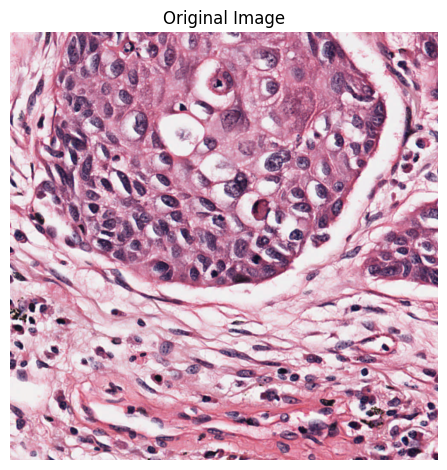

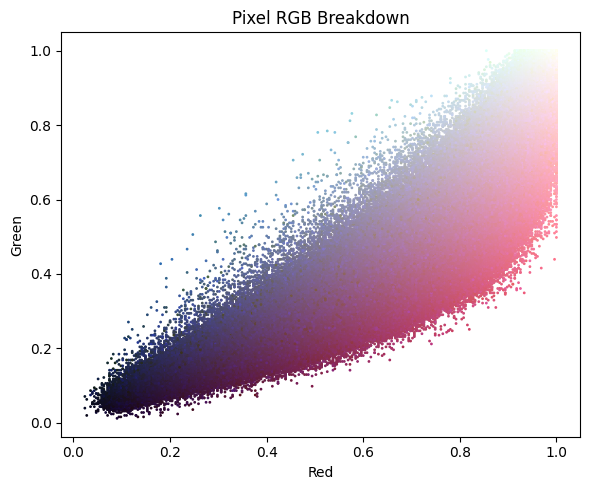

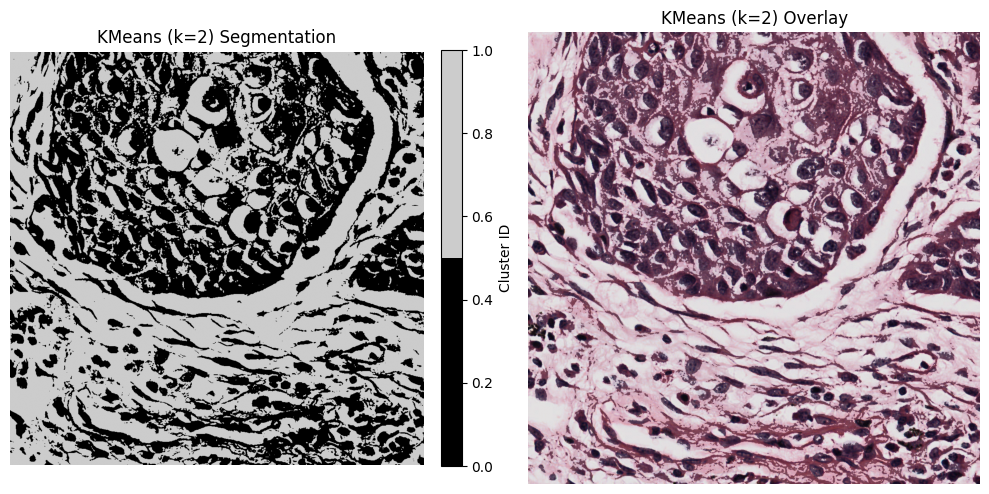

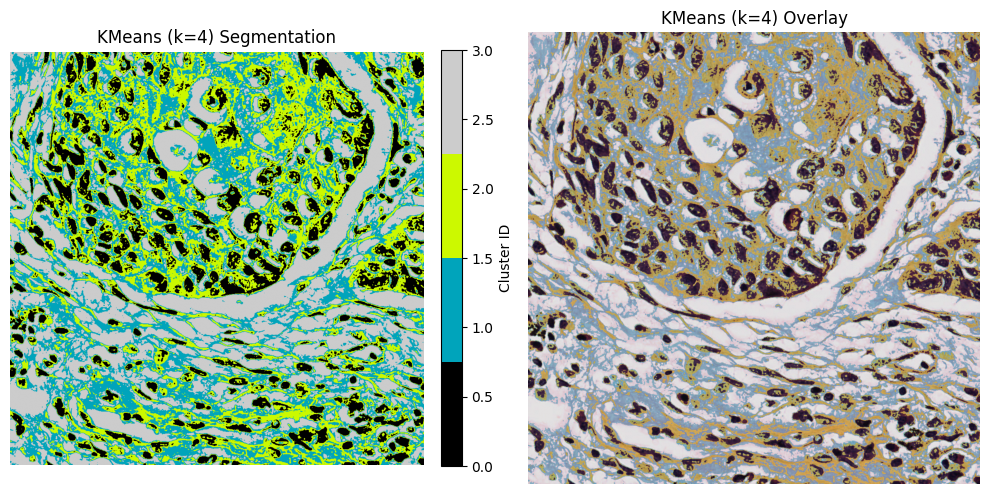

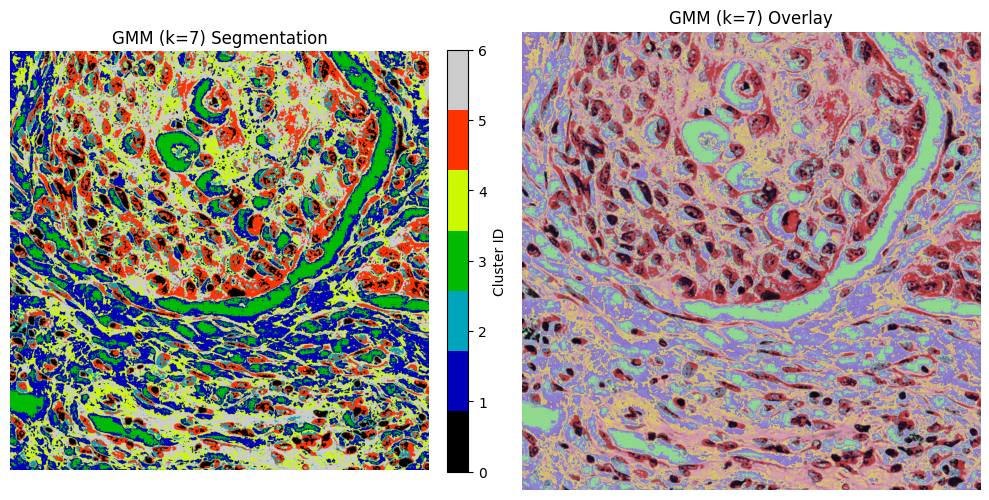

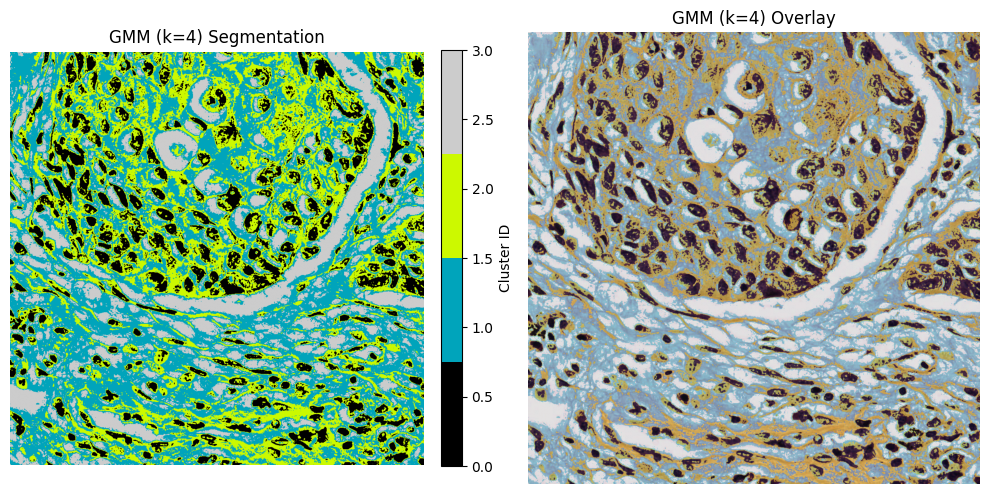


✅ Done. All plots and masks saved in: pixel_level1/


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import tifffile

def load_image(path):
    image = tifffile.imread(path)
    if image.ndim == 2:
        image = np.stack([image]*3, axis=-1)
    elif image.shape[2] > 3:
        image = image[:, :, :3]
    return image

def cluster_kmeans(X, k):
    model = KMeans(n_clusters=k, random_state=42).fit(X)
    return model.labels_

def cluster_gmm(X, k):
    model = GaussianMixture(n_components=k, random_state=42).fit(X)
    return model.predict(X)

def kmeans_elbo(X):
    inertias = []
    for k in range(2, 8):
        km = KMeans(n_clusters=k, random_state=42).fit(X)
        inertias.append(km.inertia_)
    best_k = 2 + np.argmin(np.diff(inertias))
    return cluster_kmeans(X, best_k), best_k

def gmm_elbo(X):
    lowest_bic = np.inf
    best_k = 2
    for k in range(2, 8):
        gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
        bic = gmm.bic(X)
        if bic < lowest_bic:
            lowest_bic = bic
            best_k = k
    return cluster_gmm(X, best_k), best_k

def save_and_plot_mask(mask, image, title, filename_prefix, output_dir):
    cmap = plt.get_cmap("nipy_spectral", np.max(mask)+1)
    mask_rgb = (cmap(mask / np.max(mask))[:, :, :3] * 255).astype(np.uint8)
    overlay = (0.5 * image + 0.5 * mask_rgb).astype(np.uint8)

    # Save
    plt.imsave(os.path.join(output_dir, f"{filename_prefix}.png"), mask_rgb)
    plt.imsave(os.path.join(output_dir, f"{filename_prefix}_overlay.png"), overlay)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    im1 = axes[0].imshow(mask, cmap=cmap, vmin=0, vmax=np.max(mask))
    axes[0].set_title(f"{title} Segmentation")
    axes[0].axis('off')
    cbar = fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    cbar.set_label('Cluster ID')

    axes[1].imshow(image)
    axes[1].imshow(mask, cmap=cmap, alpha=0.4, vmin=0, vmax=np.max(mask))
    axes[1].set_title(f"{title} Overlay")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

def save_and_plot_pixel_breakdown(X_rgb, filename_prefix, output_dir):
    plt.figure(figsize=(6, 5))
    plt.scatter(X_rgb[:, 0], X_rgb[:, 1], c=X_rgb, s=1)
    plt.xlabel("Red")
    plt.ylabel("Green")
    plt.title("Pixel RGB Breakdown")
    plt.tight_layout()
    path = os.path.join(output_dir, f"{filename_prefix}_pixel_breakdown.png")
    plt.savefig(path)
    plt.show()

def main():
    data_folder = "."  # current folder
    filename = "TCGA-21-5784-01Z-00-DX1"
    img_path = os.path.join(data_folder, f"{filename}.tif")
    output_dir = "pixel_level1"
    os.makedirs(output_dir, exist_ok=True)

    image = load_image(img_path)
    H, W, _ = image.shape
    X = image.reshape(-1, 3).astype(np.float32)
    X_rgb = X / 255.0

    # Save and show original
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{filename}_original.png"))
    plt.show()

    # Pixel RGB scatter
    save_and_plot_pixel_breakdown(X_rgb, filename, output_dir)

    # KMeans ELBO
    km_elbo_labels, k1 = kmeans_elbo(X_rgb)
    km_elbo_mask = km_elbo_labels.reshape(H, W)
    save_and_plot_mask(km_elbo_mask, image, f"KMeans (k={k1})", f"{filename}_kmeans_elbo", output_dir)

    # KMeans k=4
    km4_labels = cluster_kmeans(X_rgb, 4)
    km4_mask = km4_labels.reshape(H, W)
    save_and_plot_mask(km4_mask, image, "KMeans (k=4)", f"{filename}_kmeans4", output_dir)

    # GMM ELBO
    gmm_elbo_labels, k2 = gmm_elbo(X_rgb)
    gmm_elbo_mask = gmm_elbo_labels.reshape(H, W)
    save_and_plot_mask(gmm_elbo_mask, image, f"GMM (k={k2})", f"{filename}_gmm_elbo", output_dir)

    # GMM k=4
    gmm4_labels = cluster_gmm(X_rgb, 4)
    gmm4_mask = gmm4_labels.reshape(H, W)
    save_and_plot_mask(gmm4_mask, image, "GMM (k=4)", f"{filename}_gmm4", output_dir)

    print(f"\n Done. All plots and masks saved in: {output_dir}/")

if __name__ == "__main__":
    main()


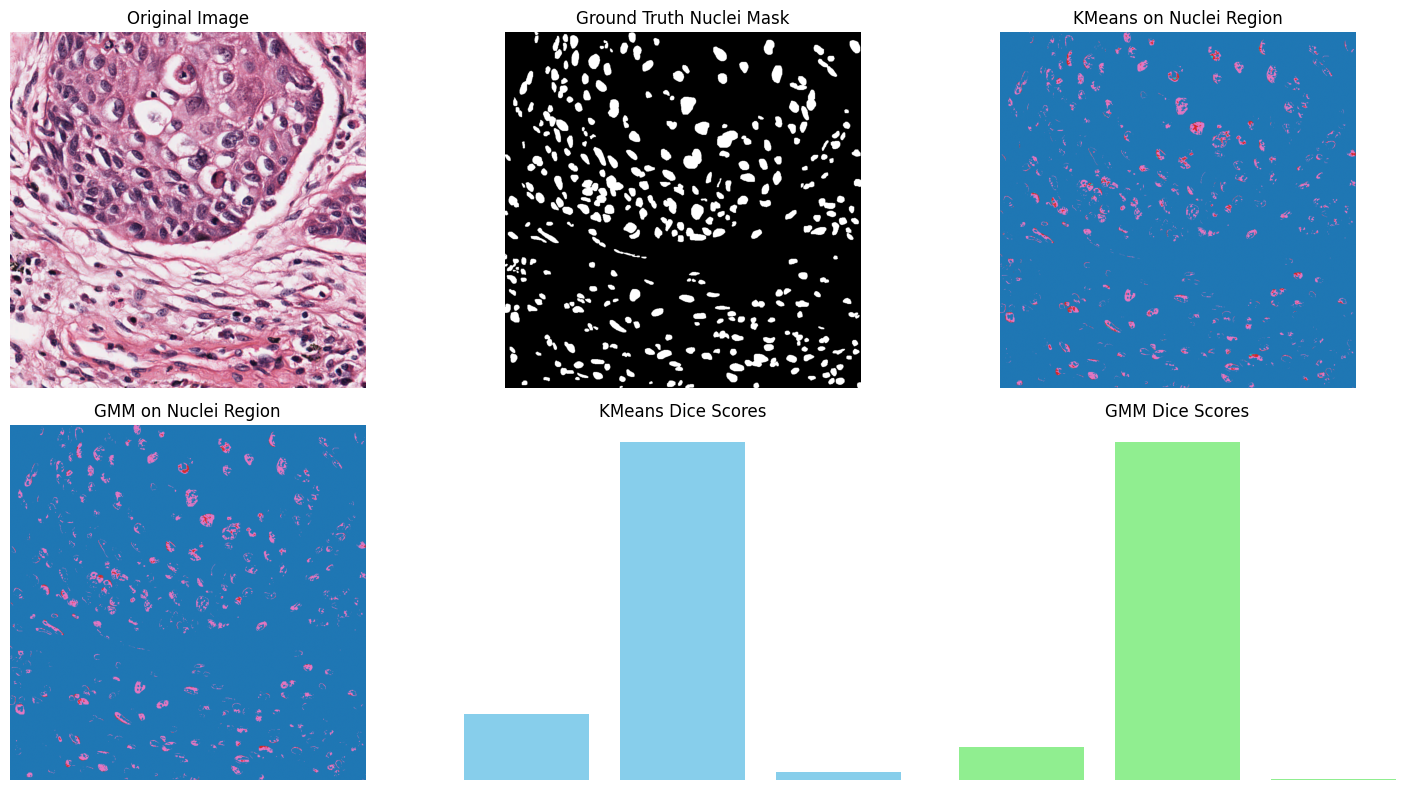

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from PIL import Image, ImageDraw
from lxml import etree
import tifffile

# === CONFIG ===
img_name = "TCGA-21-5784-01Z-00-DX1"  # replace with your image
img_path = f"{img_name}.tif"
xml_path = f"{img_name}.xml"
n_clusters = 4  # background + 3 foreground

# === Load Image ===
def load_image(path):
    img = tifffile.imread(path)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    return img[:, :, :3]

# === Load Nuclei Ground Truth from XML ===
def load_nuclei_mask(xml_path, shape):
    mask = Image.new("L", (shape[1], shape[0]), 0)
    tree = etree.parse(xml_path)
    for region in tree.findall(".//Annotation/Regions/Region"):
        points = [(float(v.get("X")), float(v.get("Y"))) for v in region.findall("./Vertices/Vertex")]
        ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
    return np.array(mask, dtype=np.uint8)

# === Clustering Functions ===
def cluster_kmeans(X, k):
    return KMeans(n_clusters=k, random_state=42).fit_predict(X)

def cluster_gmm(X, k):
    return GaussianMixture(n_components=k, random_state=42).fit_predict(X)

# === Dice Coefficient ===
def dice_score(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    return (2.0 * intersection) / (pred.sum() + gt.sum() + 1e-8)

# === Run pipeline ===
image = load_image(img_path)
H, W, _ = image.shape
flat_img = image.reshape(-1, 3).astype(np.float32) / 255.0

gt_mask = load_nuclei_mask(xml_path, (H, W))

# Apply clustering
kmeans_labels = cluster_kmeans(flat_img, n_clusters).reshape(H, W)
gmm_labels = cluster_gmm(flat_img, n_clusters).reshape(H, W)

# Restrict to nuclei-only region
kmeans_labels_nuclei = np.where(gt_mask == 1, kmeans_labels, 0)
gmm_labels_nuclei = np.where(gt_mask == 1, gmm_labels, 0)

# Compute Dice score per cluster (skip label 0)
kmeans_dice = []
gmm_dice = []

for i in range(1, n_clusters):
    k_pred = (kmeans_labels_nuclei == i).astype(np.uint8)
    g_pred = (gmm_labels_nuclei == i).astype(np.uint8)
    kmeans_dice.append(dice_score(k_pred, gt_mask))
    gmm_dice.append(dice_score(g_pred, gt_mask))

# === Visualize Results ===
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

axs[0, 0].imshow(image)
axs[0, 0].set_title("Original Image")
axs[0, 1].imshow(gt_mask, cmap="gray")
axs[0, 1].set_title("Ground Truth Nuclei Mask")
axs[0, 2].imshow(kmeans_labels_nuclei, cmap="tab10")
axs[0, 2].set_title("KMeans on Nuclei Region")

axs[1, 0].imshow(gmm_labels_nuclei, cmap="tab10")
axs[1, 0].set_title("GMM on Nuclei Region")
axs[1, 1].bar(range(1, n_clusters), kmeans_dice, color="skyblue")
axs[1, 1].set_title("KMeans Dice Scores")
axs[1, 1].set_xlabel("Cluster")
axs[1, 1].set_ylabel("Dice")

axs[1, 2].bar(range(1, n_clusters), gmm_dice, color="lightgreen")
axs[1, 2].set_title("GMM Dice Scores")
axs[1, 2].set_xlabel("Cluster")
axs[1, 2].set_ylabel("Dice")

for ax in axs.flat:
    ax.axis('off') if not isinstance(ax, plt.Axes) or "bar" not in ax.get_title().lower() else None

plt.tight_layout()
plt.show()
